In [1]:
import pickle
import os
from glob import glob
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from model import analyse, visualise
import numpy as np

plt.style.use(style="ggplot")

# font size in the paper is 9
plt.rcParams.update({"font.size": 9})

# widths of figures in inches
TWO_COLUMN_FIG_WIDTH = 6.25963
# TWO_COLUMN_FIG_WIDTH = 7.00697
# SINGLE_COLUMN_FIG_WIDTH = 3.3374

# Experiment 4mini

Let's read in the files:

In [2]:
output_dir = "./experiments/experiment4mini/experiment4mini_output"
file_pattern = "experiment4_results_*.pickle"

results = []

for file_path in glob(os.path.join(output_dir, file_pattern)):

    with open(file_path, "rb") as f:
        run_results = pickle.load(f)
        results.append(run_results)

In [4]:
len(results)

93

In [5]:
ids = tuple(r['run_id'] for r in results)
for i in range(96):
    if i not in ids:
        print(i)

3
90
91


In [6]:
list(results[0].keys())

['run_id',
 'duration',
 'attack_reward',
 'prob_indifferent',
 'params',
 'run_length',
 'agent_df',
 'lower_tree_query_data',
 'actions',
 'rewards',
 'action_qualities']

In [7]:
subset = [res["duration"] for res in results]
avg_duration = sum((d for d in subset), start=datetime.timedelta(0)) / len(subset)
print(f'Average: {avg_duration}')
print(f'Maximum: {max(subset)}')

Average: 7:42:50.655483
Maximum: 10:55:39.439778


In [8]:
# check which runs didn't finish
n = 0
for r in results:
    if r["run_length"] < 100:
        print(f"{r['run_id']}: {r['run_length']}, {r['softargmax_coefficient']:.2f}, {r['exploration_coef']:.2f}, {r['reasoning_level']}")
        n += 1

print(n)

0


All of the runs finished. Previously I found out many level 0 runs do not finish. Here we only use level 1.

Let's visualise the query success rates as averages over all runs over time.

In [9]:
# let's turn the results into a DataFrame
rows = []

# the simulations are level 1
tree_levels = {"Civ 0,": 1, "Civ 1,": 1}

for run_result in results:

    for t, time_step_data in enumerate(run_result["lower_tree_query_data"]):
        for tree, values in time_step_data.items():
            # if there are no queries, skip
            if values[0] == 0:
                continue

            level = tree_levels[tree]

            rows.append((t, tree, *values))

query_data = pd.DataFrame(
    rows,                       
    columns=(
        'time', 
        'tree',
        'n_queries', 
        'prop_successful', 
        'prop_missing_node', 
        'prop_diverged_belief', 
        'prop_some_actions_unexpanded'
    )
)

query_data

,time,tree,n_queries,prop_successful,prop_missing_node,prop_diverged_belief,prop_some_actions_unexpanded
0,0,"Civ 0,",22142,0.748713,0.000000,0.063996,0.187291
1,0,"Civ 1,",22088,0.947166,0.000091,0.005297,0.047447
2,1,"Civ 0,",22326,0.691839,0.000314,0.091149,0.216698
3,1,"Civ 1,",22322,0.943464,0.000045,0.006854,0.049637
4,2,"Civ 0,",22344,0.816998,0.001522,0.017320,0.164160
...,...,...,...,...,...,...,...
18781,98,"Civ 1,",22573,0.000000,0.800292,0.199708,0.000000
18782,99,"Civ 0,",22459,0.959660,0.003250,0.007970,0.029120
18783,99,"Civ 1,",22211,0.000000,0.795642,0.204358,0.000000
18784,100,"Civ 0,",22483,0.970467,0.003336,0.004893,0.021305


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


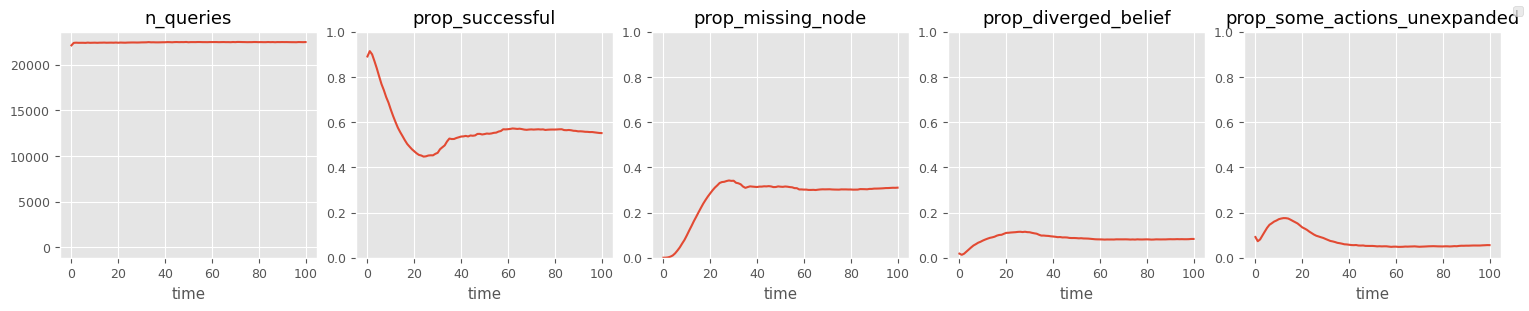

In [10]:
# plot
fig, axs = plt.subplots(nrows=1, ncols=5, constrained_layout=True, figsize=(15,3))

metrics = ["n_queries", "prop_successful", "prop_missing_node", "prop_diverged_belief", "prop_some_actions_unexpanded"]

for i, metric in enumerate(metrics):

    avg_metric = query_data.groupby("time")[metric].mean()

    axs[i].plot(avg_metric.index, avg_metric)

    axs[i].set_title(metric)
    axs[i].set_xlabel('time')

    if metric != "n_queries":
        axs[i].set_ylim((0,1))
    else:
        # add point 0 to data limits so scaling is correct
        axs[i].update_datalim([(0, 0)])
    
fig.legend()
plt.show()

Let's calculate the average proportion of all actions that are attacks at each reward level:

In [12]:
rows = []

for run_result in results:

    run_id = run_result["run_id"]
    run_length = run_result["run_length"]
    attack_reward = run_result["attack_reward"]
    prob_indifferent = run_result["params"]["prob_indifferent"]
    reasoning_level = run_result["params"]["reasoning_level"]
    exploration_coef = run_result["params"]["exploration_coef"]
    softargmax_coef = run_result["params"]["softargmax_coef"]

    run_actions = run_result["actions"]
    prop_no_action = ((run_actions["action"] == 0) | ((run_actions["action"] == "a") & (run_actions["attack_successful"].isnull()))).mean()
    prop_attack = ((run_actions["action"] == "a") & (~run_actions["attack_successful"].isnull())).mean()
    #prop_no_action = (run_actions["action"] == 0).mean()
    #prop_attack = (run_actions["action"] == "a").mean()
    prop_hide = ((run_actions["action"] == 1)).mean()
    rows.append((run_id, run_length, attack_reward, prob_indifferent, reasoning_level, exploration_coef, softargmax_coef, prop_no_action, prop_attack, prop_hide))

prop_action_data = pd.DataFrame(rows, columns=('run_id', 'run_length', 'attack_reward', 'prob_indifferent', 'reasoning_level', 'exploration_coef', 'softargmax_coef', 
                                               'prop_no_action', 'prop_attack', 'prop_hide'))

# add bins for attack reward
# bins = np.linspace(-0.2, 0.1, 31)
# prop_action_data["attack_reward_bin"] = pd.cut(x=prop_action_data["attack_reward"], bins=bins, include_lowest=True)

In [14]:
prop_action_data

,run_id,run_length,attack_reward,prob_indifferent,reasoning_level,exploration_coef,softargmax_coef,prop_no_action,prop_attack,prop_hide
0,20,101,0.075038,0.5,1,0.5,0.1,0.445545,0.465347,0.089109
1,43,101,0.016999,0.5,1,0.5,0.1,0.485149,0.465347,0.049505
2,32,101,0.037403,0.5,1,0.5,0.1,0.465347,0.485149,0.049505
3,51,101,0.066330,0.5,1,0.5,0.1,0.455446,0.475248,0.069307
4,0,101,-0.070691,0.5,1,0.5,0.1,0.891089,0.000000,0.108911
...,...,...,...,...,...,...,...,...,...,...
88,9,101,-0.189486,0.5,1,0.5,0.1,0.871287,0.000000,0.128713
89,70,101,-0.175394,0.5,1,0.5,0.1,0.900990,0.000000,0.099010
90,13,101,-0.008091,0.5,1,0.5,0.1,0.881188,0.029703,0.089109
91,62,101,0.027692,0.5,1,0.5,0.1,0.475248,0.455446,0.069307


In [16]:
prop_action_data.groupby("attack_reward_bin").size()

attack_reward_bin
(-0.201, -0.19]      24
(-0.19, -0.18]       24
(-0.18, -0.17]       24
(-0.17, -0.16]       32
(-0.16, -0.15]       16
(-0.15, -0.14]       32
(-0.14, -0.13]       32
(-0.13, -0.12]       32
(-0.12, -0.11]       23
(-0.11, -0.1]        24
(-0.1, -0.09]         8
(-0.09, -0.08]       40
(-0.08, -0.07]       24
(-0.07, -0.06]       16
(-0.06, -0.05]       32
(-0.05, -0.04]       24
(-0.04, -0.03]       32
(-0.03, -0.02]       16
(-0.02, -0.01]       24
(-0.01, 2.78e-17]    23
(2.78e-17, 0.01]     24
(0.01, 0.02]         48
(0.02, 0.03]         16
(0.03, 0.04]         16
(0.04, 0.05]         32
(0.05, 0.06]         16
(0.06, 0.07]         40
(0.07, 0.08]          8
(0.08, 0.09]         40
(0.09, 0.1]          24
dtype: int64

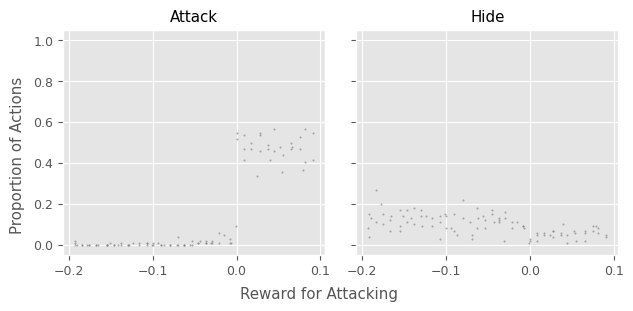

In [13]:
metrics = ("prop_attack", "prop_hide")
fancy_titles = {"prop_no_action": "No action", "prop_attack": "Attack", "prop_hide": "Hide"}

prop_action_data_ = prop_action_data[prop_action_data["run_length"] >= 50]

fig, axs = plt.subplots(ncols=len(metrics), nrows=1, constrained_layout=True, figsize=(TWO_COLUMN_FIG_WIDTH, 3), sharey=True, sharex=True)

for i, metric in enumerate(metrics):

    axs[i].scatter(x=prop_action_data_["attack_reward"], y=prop_action_data_[metric], s=1, c="grey", alpha=0.5)

    # prop_action_data_groups = prop_action_data_.groupby("attack_reward_bin")
    # avg_metric = prop_action_data_groups.mean()[metric]
    # avg_metric_error_margin = prop_action_data_groups.aggregate(lambda x: analyse.t_confidence_interval(x)[1])[metric]
    # midpoints = pd.IntervalIndex(avg_metric.index).mid

    # # show discontinuity at 0
    # if metric == "prop_attack":
    #     subset = midpoints < 0
    #     lines = axs[i].plot(midpoints[subset], avg_metric[subset])
    #     color = lines[0].get_color()
    #     axs[i].fill_between(midpoints[subset], avg_metric[subset]-avg_metric_error_margin[subset], avg_metric[subset] + avg_metric_error_margin[subset], color=color, alpha=0.5)

    #     subset = midpoints > 0
    #     axs[i].plot(midpoints[subset], avg_metric[subset], color=color)
    #     axs[i].fill_between(midpoints[subset], avg_metric[subset]-avg_metric_error_margin[subset], avg_metric[subset] + avg_metric_error_margin[subset], color=color, alpha=0.5)
    # else:
    #     axs[i].plot(midpoints, avg_metric)
    #     axs[i].fill_between(midpoints, avg_metric-avg_metric_error_margin, avg_metric + avg_metric_error_margin, alpha=0.5)

    #axs[i].errorbar(x=midpoints, y=avg_metric, yerr=avg_metric_error_margin, capsize=3, fmt="none")

    #axs[i].set_xlabel("Reward for attacking")
    #axs[i].set_ylabel("Proportion of actions")
    axs[i].set_title(fancy_titles[metric], fontsize="large")
    axs[i].set_ylim((-0.05, 1.05))

fig.supxlabel("Reward for Attacking", color=plt.rcParams['xtick.color'])
fig.supylabel("Proportion of Actions", color=plt.rcParams['xtick.color'])

#plt.savefig("paper/experiment4mini_prop_actions.pdf")
plt.show()

Let us then start to quantify error in predicting the other agents' actions. First, we will plot the prediction error (norm of the difference vector of action utility estimates) over time for different attack rewards.

In [20]:
rows = []

for run_result in results:
    attack_reward = run_result["attack_reward"]
    reasoning_level = run_result["reasoning_level"]
    exploration_coef = run_result["exploration_coef"]
    softargmax_coef = run_result["softargmax_coefficient"]
    action_dist_0 = run_result["action_dist_0"]
    discount_factor = run_result["discount_factor"]

    if reasoning_level == 0:
        continue

    action_utility_estimates = run_result["action_qualities"]

    for t, t_data in action_utility_estimates.groupby("time"):

        for estimator, actor in ((0,1), (1,0)):

            actor_estimate = t_data[(t_data["estimator"] == actor) & (t_data["actor"] == actor)]["qualities"].iloc[0]
            estimator_estimate = t_data[(t_data["estimator"] == estimator) & (t_data["actor"] == actor)]["qualities"].iloc[0]
            difference = np.linalg.norm(np.array(actor_estimate) - np.array(estimator_estimate))
            rows.append((attack_reward, t, exploration_coef, softargmax_coef, action_dist_0, discount_factor, difference))

action_utility_estimate_data = pd.DataFrame(rows, columns=("attack_reward", "time", "exploration_coef", "softargmax_coef", 
                                                           "action_dist_0", "discount_factor", "distance"))

KeyboardInterrupt: 

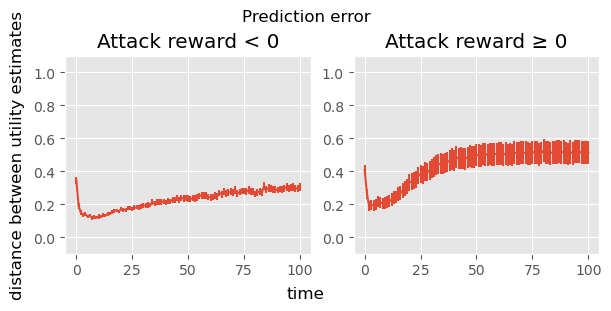

In [50]:
fig, axs = plt.subplots(constrained_layout=True, nrows=1, ncols=2, figsize=(6, 3))

negative_attack_reward = action_utility_estimate_data[action_utility_estimate_data["attack_reward"] < 0]
positive_attack_reward = action_utility_estimate_data[action_utility_estimate_data["attack_reward"] >= 0]

for i, (attack_reward_data) in enumerate((negative_attack_reward, positive_attack_reward)):

    avg_action_utility_estimate = attack_reward_data.groupby("time")["distance"].mean()
    avg_action_utility_estimate_error_margin = attack_reward_data.groupby("time")["distance"].aggregate(lambda x: analyse.t_confidence_interval(x)[1])

    if avg_action_utility_estimate.max() > 0.7:
        print(avg_action_utility_estimate)

    #lines = ax.plot(avg_action_utility_estimate.index, avg_action_utility_estimate, label=attack_reward)
    axs[i].errorbar(x=avg_action_utility_estimate.index, y=avg_action_utility_estimate, yerr=avg_action_utility_estimate_error_margin, label=attack_reward)
    axs[i].set_title(f"Attack reward {'< 0' if i == 0 else '≥ 0'}")
    axs[i].set_ylim((-0.1, 1.1))

fig.supxlabel("time")
fig.supylabel("distance between utility estimates")
fig.suptitle("Prediction error")
plt.show()